In [98]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
# ===================================================================
# 1. LOAD DATA
# ===================================================================
datadir = 'dataset'
actions = ['left', 'no_action', 'right']
data_list = []

for action in actions:
    folder_path = os.path.join(datadir, action)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.png'):
            file_path = os.path.join(folder_path, file_name)
            data_list.append({
                'image': file_path,
                'action': action
            })

data = pd.DataFrame(data_list)
print(f"✅ Total images loaded: {len(data)}")

# Map actions to numbers
action_map = {'left': 0, 'no_action': 1, 'right': 2}
data['action_num'] = data['action'].map(action_map)


✅ Total images loaded: 3200



📊 Original Data Distribution:
action
no_action    1200
left         1000
right        1000
Name: count, dtype: int64


Text(0, 0.5, 'Count')

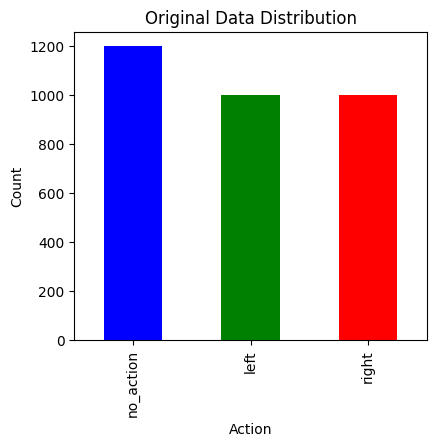

In [100]:
# ===================================================================
# 2. ANALYZE DATA DISTRIBUTION
# ===================================================================
print("\n📊 Original Data Distribution:")
print(data['action'].value_counts())

# Visualize original distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
data['action'].value_counts().plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Original Data Distribution')
plt.xlabel('Action')
plt.ylabel('Count')


✅ Using 500 samples per class
   Total training samples: 1500


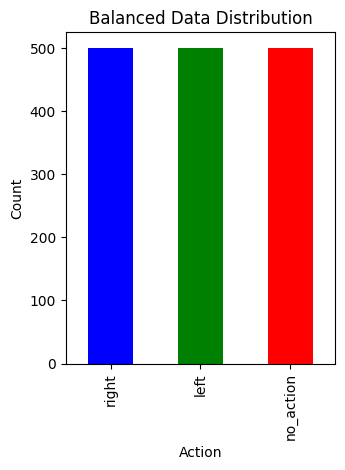

In [ ]:
# ===================================================================
# 3. SMART BALANCING OF DATASET
# ===================================================================
# Find the minority class count
min_samples = data['action_num'].value_counts().min()

# ✅ FIXED: Use ALL available data up to reasonable limit
# Don't throw away data unless severely imbalanced
if min_samples < 100:
    print(f"\n⚠️ WARNING: Only {min_samples} samples in minority class!")
    print("   Consider collecting more data for better performance.")
    samples_per_bin = min_samples
else:
    # Use minority class count or cap at reasonable maximum
    samples_per_bin = min(min_samples, 500)  # Cap at 500 per class max

print(f"\n✅ Using {samples_per_bin} samples per class")
print(f"   Total training samples: {samples_per_bin * 3}")

# Balance the dataset
balanced_data = pd.DataFrame()
for action in data['action_num'].unique():
    action_data = data[data['action_num'] == action]
    action_data = shuffle(action_data, random_state=42)
    balanced_data = pd.concat([balanced_data, action_data[:samples_per_bin]])

balanced_data = balanced_data.reset_index(drop=True)
balanced_data = shuffle(balanced_data, random_state=42)

# Visualize balanced distribution
plt.subplot(1, 2, 2)
balanced_data['action'].value_counts().plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Balanced Data Distribution')
plt.xlabel('Action')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


✅ Train/Valid split: 1200/300


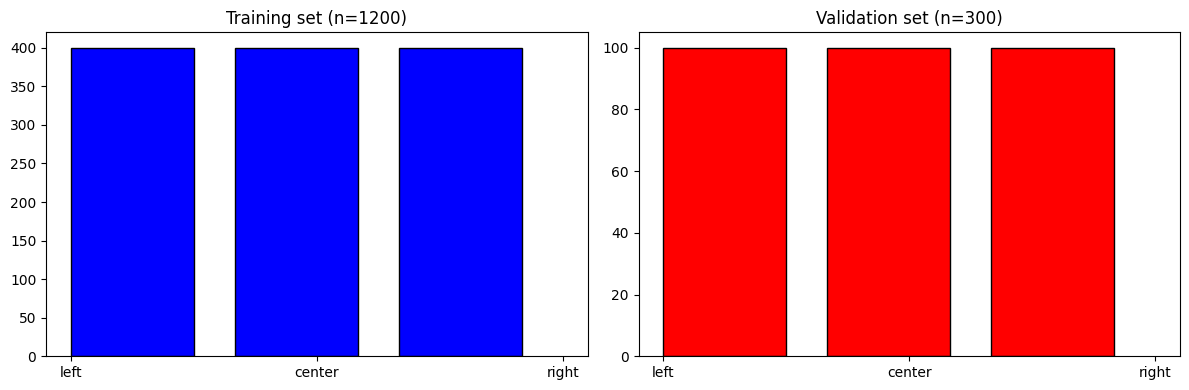

In [102]:
# ===================================================================
# 4. TRAIN/VALIDATION SPLIT
# ===================================================================
X_train, X_valid, y_train, y_valid = train_test_split(
    balanced_data['image'], 
    balanced_data['action_num'], 
    test_size=0.2, 
    random_state=42,
    stratify=balanced_data['action_num']  # Ensure balanced split
)

print(f"\n✅ Train/Valid split: {len(X_train)}/{len(X_valid)}")

# Visualize split distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=3, width=0.5, color='blue', edgecolor='black')
axes[0].set_title(f'Training set (n={len(y_train)})')
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['left', 'center', 'right'])
axes[1].hist(y_valid, bins=3, width=0.5, color='red', edgecolor='black')
axes[1].set_title(f'Validation set (n={len(y_valid)})')
axes[1].set_xticks([0, 1, 2])
axes[1].set_xticklabels(['left', 'center', 'right'])
plt.tight_layout()
plt.show()


🔄 Preprocessing images...
✅ Training set shape: (1200, 400, 200, 3)
✅ Validation set shape: (300, 400, 200, 3)


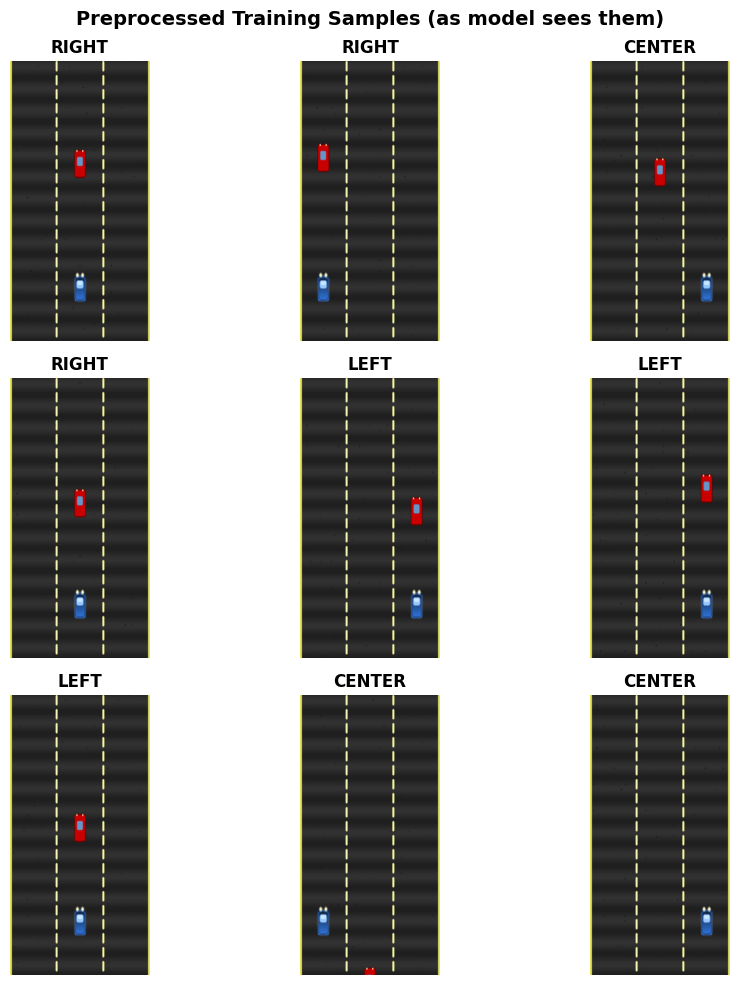

In [103]:
# ===================================================================
# 5. PREPROCESSING
# ===================================================================
def img_preprocess(img):
    """Preprocess image - matches game pipeline"""
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 400))  # Width, Height
    img = img / 255.0
    return img

print("\n🔄 Preprocessing images...")
X_train = np.array([img_preprocess(cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)) for p in X_train])
X_valid = np.array([img_preprocess(cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)) for p in X_valid])
y_train = np.array(y_train)
y_valid = np.array(y_valid)

print(f'✅ Training set shape: {X_train.shape}')
print(f'✅ Validation set shape: {X_valid.shape}')

# Visualize preprocessed samples
num_examples = 9
indices = np.random.choice(len(X_train), num_examples, replace=False)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
action_names = ['LEFT', 'CENTER', 'RIGHT']

for i, ax in enumerate(axes.flat):
    # Convert YUV back to RGB for visualization
    img_yuv = (X_train[indices[i]] * 255).astype(np.uint8)
    img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    
    ax.imshow(img_rgb)
    ax.set_title(f"{action_names[y_train[indices[i]]]}", fontsize=12, fontweight='bold')
    ax.axis('off')

plt.suptitle('Preprocessed Training Samples (as model sees them)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
# ===================================================================
# 6. BUILD MODEL
# ===================================================================
print("\n Building model...")

# ✅ SIMPLIFIED MODEL - Better for small datasets
model = Sequential([
    Conv2D(24, (5, 5), strides=(2, 2), activation='relu', input_shape=(400, 200, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),

    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(8, activation='relu'),
    Dropout(0.1),
    Dense(3, activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



🏗️ Building model...


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 198, 98, 24)    │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 99, 49, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 97, 47, 16)     │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 48, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 46, 21, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 23, 10, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 1840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16)             │        29,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,075 (140.92 KB)

 Trainable params: 36,075 (140.92 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:

# ===================================================================
# 7. TRAINING WITH CALLBACKS
# ===================================================================
print("\n🚀 Starting training...")

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Save best model
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,  # More epochs with early stopping
    validation_data=(X_valid, y_valid),
    batch_size=64,  # Smaller batch size for small datasets
    shuffle=True,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


🚀 Starting training...
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3232 - loss: 1.1007
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.3234 - loss: 1.1007 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 2/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3680 - loss: 1.0978
Epoch 2: val_accuracy improved from 0.33333 to 0.45667, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3674 - loss: 1.0978 - val_accuracy: 0.4567 - val_loss: 1.0972
Epoch 3/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4129 - loss: 1.0957
Epoch 3: val_accuracy did not improve from 0.45667
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.4096 - loss: 1.0957 - val_accuracy: 0.3333 - val_loss: 1.0954
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3794 - loss: 1.0963
Epoch 4: val_accuracy did not improve from 0.45667
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3791 - loss: 1.0963 - val_accuracy: 0.3333 - val_loss: 1.0932
Epoch 5/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3835 - loss: 1.0951
Epoch 5: val_accuracy did not improve from 0.45667
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.3865 - loss: 1.0947 - val_accuracy: 0.3333 - val_loss: 1.0893
Epoch 6/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3525 - loss: 1.0911
Epoch 6: val_accuracy did not improve from 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4471 - loss: 1.0271 - val_accuracy: 0.4867 - val_loss: 1.0112
Epoch 10/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4697 - loss: 1.0133
Epoch 10: val_accuracy improved from 0.48667 to 0.59667, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4684 - loss: 1.0130 - val_accuracy: 0.5967 - val_loss: 0.9869
Epoch 11/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4819 - loss: 1.0007
Epoch 11: val_accuracy did not improve from 0.59667
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.4819 - loss: 0.9994 - val_accuracy: 0.5367 - val_loss: 0.9573
Epoch 12/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4326 - loss: 0.9881
Epoch 12: val_accuracy did not improve from 0.59667
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.4354 - loss: 0.9862 - val_accuracy: 0.5467 - val_loss: 0.9387
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4664 - loss: 0.9645
Epoch 13: val_accuracy did not improve from 0.59667
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.4658 - loss: 0.9643 - val_accuracy: 0.5800 - val_loss: 0.9236
Epoch 14/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4784 - loss: 0.9603
Epoch 14: val_accuracy did not impro

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5295 - loss: 0.8649 - val_accuracy: 0.6100 - val_loss: 0.7746
Epoch 18/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5251 - loss: 0.8611
Epoch 18: val_accuracy improved from 0.61000 to 0.66667, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5261 - loss: 0.8601 - val_accuracy: 0.6667 - val_loss: 0.7638
Epoch 19/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5506 - loss: 0.8347
Epoch 19: val_accuracy improved from 0.66667 to 0.71000, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5507 - loss: 0.8342 - val_accuracy: 0.7100 - val_loss: 0.7327
Epoch 20/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5551 - loss: 0.8221
Epoch 20: val_accuracy did not improve from 0.71000
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5558 - loss: 0.8217 - val_accuracy: 0.6867 - val_loss: 0.7032
Epoch 21/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5589 - loss: 0.8081
Epoch 21: val_accuracy did not improve from 0.71000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5605 - loss: 0.8069 - val_accuracy: 0.6967 - val_loss: 0.6903
Epoch 22/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5969 - loss: 0.7746
Epoch 22: val_accuracy improved from 0.71000 to 0.73667, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5985 - loss: 0.7732 - val_accuracy: 0.7367 - val_loss: 0.6783
Epoch 23/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6255 - loss: 0.7535
Epoch 23: val_accuracy improved from 0.73667 to 0.76000, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6254 - loss: 0.7533 - val_accuracy: 0.7600 - val_loss: 0.6430
Epoch 24/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6615 - loss: 0.7291
Epoch 24: val_accuracy did not improve from 0.76000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6588 - loss: 0.7296 - val_accuracy: 0.7567 - val_loss: 0.6249
Epoch 25/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6336 - loss: 0.7361
Epoch 25: val_accuracy did not improve from 0.76000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6349 - loss: 0.7351 - val_accuracy: 0.7467 - val_loss: 0.6068
Epoch 26/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6649 - loss: 0.6895
Epoch 26: val_accuracy improved from 0.76000 to 0.77667, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6629 - loss: 0.6908 - val_accuracy: 0.7767 - val_loss: 0.5926
Epoch 27/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6562 - loss: 0.6951
Epoch 27: val_accuracy did not improve from 0.77667
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6563 - loss: 0.6946 - val_accuracy: 0.7733 - val_loss: 0.5645
Epoch 28/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6574 - loss: 0.6562
Epoch 28: val_accuracy improved from 0.77667 to 0.78333, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6563 - loss: 0.6582 - val_accuracy: 0.7833 - val_loss: 0.5583
Epoch 29/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6803 - loss: 0.6517
Epoch 29: val_accuracy did not improve from 0.78333
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6786 - loss: 0.6534 - val_accuracy: 0.7767 - val_loss: 0.5515
Epoch 30/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6788 - loss: 0.6451
Epoch 30: val_accuracy did not improve from 0.78333
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6780 - loss: 0.6469 - val_accuracy: 0.7733 - val_loss: 0.5260
Epoch 31/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6797 - loss: 0.6484
Epoch 31: val_accuracy did not improve from 0.78333
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6802 - loss: 0.6475 - val_accuracy: 0.7800 - val_loss: 0.5097
Epoch 32/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6899 - loss: 0.6343
Epoch 32: val_accuracy did not impro

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6907 - loss: 0.6098 - val_accuracy: 0.7900 - val_loss: 0.4749
Epoch 36/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7207 - loss: 0.5724
Epoch 36: val_accuracy improved from 0.79000 to 0.80333, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7209 - loss: 0.5736 - val_accuracy: 0.8033 - val_loss: 0.4702
Epoch 37/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7172 - loss: 0.5960
Epoch 37: val_accuracy did not improve from 0.80333
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7183 - loss: 0.5947 - val_accuracy: 0.7933 - val_loss: 0.4474
Epoch 38/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6999 - loss: 0.6040
Epoch 38: val_accuracy did not improve from 0.80333
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7023 - loss: 0.6018 - val_accuracy: 0.8000 - val_loss: 0.4436
Epoch 39/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7170 - loss: 0.6101
Epoch 39: val_accuracy did not improve from 0.80333
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7193 - loss: 0.6064 - val_accuracy: 0.7967 - val_loss: 0.4357
Epoch 40/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7002 - loss: 0.5706
Epoch 40: val_accuracy did not impro

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7492 - loss: 0.5168 - val_accuracy: 0.8300 - val_loss: 0.3665
Epoch 47/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7669 - loss: 0.4874
Epoch 47: val_accuracy improved from 0.83000 to 0.83667, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7655 - loss: 0.4903 - val_accuracy: 0.8367 - val_loss: 0.3613
Epoch 48/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7606 - loss: 0.4844
Epoch 48: val_accuracy did not improve from 0.83667
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7592 - loss: 0.4864 - val_accuracy: 0.8333 - val_loss: 0.3512
Epoch 49/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7750 - loss: 0.4792
Epoch 49: val_accuracy did not improve from 0.83667
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7744 - loss: 0.4799 - val_accuracy: 0.8267 - val_loss: 0.3396
Epoch 50/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7560 - loss: 0.4951
Epoch 50: val_accuracy did not improve from 0.83667
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.7556 - loss: 0.4952 - val_accuracy: 0.8300 - val_loss: 0.3366
Restoring model weights from the end of the best epoch: 50.



📈 Training Complete!


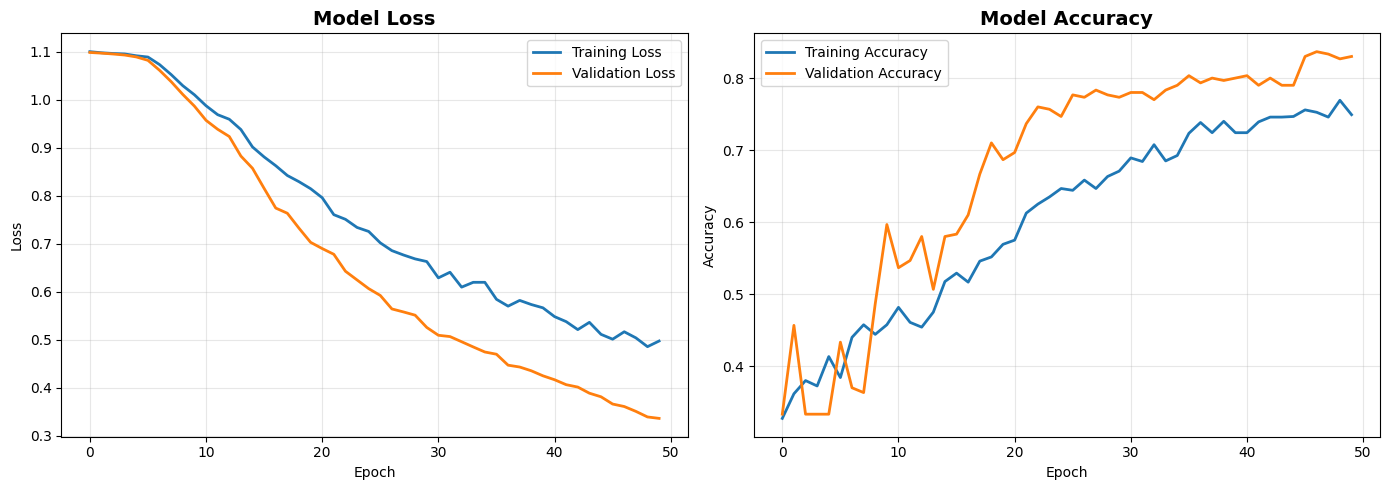


FINAL RESULTS
Training Accuracy:   74.92%
Validation Accuracy: 83.00%
Training Loss:       0.4977
Validation Loss:     0.3366

✅ Model looks good!

✅ Model saved as 'model.h5' and 'best_model.h5'


In [ ]:

# ===================================================================
# 8. EVALUATE AND VISUALIZE RESULTS
# ===================================================================
print("\n📈 Training Complete!")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Training Accuracy:   {final_train_acc:.2%}")
print(f"Validation Accuracy: {final_val_acc:.2%}")
print(f"Training Loss:       {final_train_loss:.4f}")
print(f"Validation Loss:     {final_val_loss:.4f}")
print("="*60)


print("\n✅ Model saved as'best_model.h5'")